In [21]:
from typing import Optional, Callable
import os.path as osp

import pandas as pd 
import numpy as np

from rdkit import Chem
from rdkit.Chem import PeriodicTable

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import scatter
from torch_geometric.nn import GCNConv, RGCNConv, MLP, MessagePassing, aggr
from torch_geometric.data import (
    InMemoryDataset, 
    download_url,
    Data
)
from torch_geometric.loader import DataLoader

## Feature vectors

In [2]:
def oneHotEncoding(x, values):
    """
    Helper function to encode the given value as a one-hot vector

    :param x: value to encode
    :param values: encoding vector, i.e. contains every possible values of x
    """

    return [int(x == value) for value in values]

In [3]:
def getAtomFeatureVector(atom):

    # Setup one-hot encoding vectors
    atoms = ["B", "C", "N", "O", "F", "Si", "P", "S", "As", "Se", "Br", "Te", "I", "At"]
    degrees = list(range(6))
    hybridizations = [
        Chem.HybridizationType.SP,
        Chem.HybridizationType.SP2,
        Chem.HybridizationType.SP3,
        Chem.HybridizationType.SP3D,
        Chem.HybridizationType.SP3D2,
        Chem.HybridizationType.OTHER,
    ]
    hydrogens = list(range(5))
    chirality_types = [
        Chem.ChiralType.CHI_TETRAHEDRAL_CW, 
        Chem.ChiralType.CHI_TETRAHEDRAL_CCW
    ]
    
#     atom_encoding = [
#         [*[0]*(len(atoms)-1) + [1]] 
#         if atom.IsMetal()
#         else oneHotEncoding(atom.GetSymbol(), atoms)
#     ]

    return [
        *oneHotEncoding(atom.GetSymbol(), atoms),
        *oneHotEncoding(atom.GetDegree(), degrees),
        atom.GetFormalCharge(),
        *oneHotEncoding(atom.GetHybridization(), hybridizations),
        *oneHotEncoding(atom.GetTotalNumHs(), hydrogens),
        int(atom.GetChiralTag() != Chem.ChiralType.CHI_UNSPECIFIED),
        *oneHotEncoding(atom.GetChiralTag(), chirality_types)
    ]

In [4]:
def getBondFeatureVector(bond):
    
    # Setup one-hot encoding vectors
    bond_types = [
        Chem.BondType.SINGLE, 
        Chem.BondType.DOUBLE, 
        Chem.BondType.TRIPLE, 
        Chem.BondType.AROMATIC
    ]
    
    stereo_types = [
        Chem.BondStereo.STEREONONE, 
        Chem.BondStereo.STEREOANY, 
        Chem.BondStereo.STEREOZ, 
        Chem.BondStereo.STEREOE
    ]
    
    return [
        *oneHotEncoding(bond.GetBondType(), bond_types),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        *oneHotEncoding(bond.GetStereo(), stereo_types)
    ]


def getEdgeTypes(e):
    
    edge_types = np.zeros(e.shape[0], dtype=int)
    
    for row in range(e.shape[0]):
        
        bond_type = list(e[row, :4]).index(1)
        is_conjugated = int(e[row, 4:5])
        in_ring = int(e[row, 5:6])
        stereo = list(e[row, 6:]).index(1)
                
        edge_type = (
            bond_type + 
            is_conjugated * 4 + 
            in_ring * 8 + 
            stereo * 16
        )
        
        edge_types[row] = edge_type
    
    return torch.tensor(edge_types, dtype=torch.long)

In [5]:
def createDataObjectFromSmiles(smiles: str, y: any):
    
    rd_mol = Chem.MolFromSmiles(smiles)
    
    # x has shape [num_atoms, num_features]
    x = torch.tensor([
        getAtomFeatureVector(atom)
        for atom in rd_mol.GetAtoms()
    ], dtype=torch.float)
    
    edge_indices, edge_attrs, edge_types = [], [], []
    for bond in rd_mol.GetBonds():
        
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        e = getBondFeatureVector(bond)
        
        # Treat molecules as undirected graphs
        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]
        
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 10)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)
    data.y = y
    
    return data

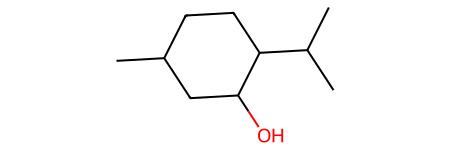

In [6]:
mol = Chem.MolFromSmiles("CC1CCC(C(C1)O)C(C)C")
mol

## Create data set

In [7]:
class SolubilityDataset(InMemoryDataset):
    
    def __init__(
        self, 
        tag: str,
        transform: Optional[Callable] = None, 
        pre_transform: Optional[Callable] =None,
        pre_filter: Optional[Callable] = None
    ):
        self.name = "solubility"
        self.tag = tag
        super().__init__("../data", transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name)

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name)
        
    @property
    def raw_file_names(self):
        return f"ESOL_{self.tag}.csv"
    
    @property
    def processed_file_names(self):
        return f"ESOL_{self.tag}.pt"
        
    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        data_list = df[["smiles", "ESOL"]].apply(
            lambda row: createDataObjectFromSmiles(*row),
            axis=1
        ).tolist()
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), osp.join(self.processed_dir, self.processed_file_names))

## Relational graph neural network (RGCN)

The GNN architecture used to predict the solubility of molecules is a relational GNN. A RGNN model extends a standard GCN model by also using edge types in the node update function,

$$
h_v^{(l+1)} = ReLU\left(\sum_{r \in R} \sum_{u \in N_v^r} W_r^{(l)} h_u^{(l)} + W_0^{(l)} h_v^{(l)}\right),
$$

with $R$ the set of edge types and $W_r^{(l)}$ a weight matrix of edge type $r$ of layer $l$ with learnable 
parameters and $N_v^r$ is the set of neighboring atoms with edge type $r$.

In [13]:
# class MLP(torch.nn.Module):
    
#     def __init__(self, input_units, hidden_units):
#         super().__init__()
        
#         self.lin1 = Linear(input_units, hidden_units)
#         self.lin2 = Linear(hidden_units, hidden_units)
#         self.lin3 = Linear(hidden_units, 1)
        
#     def forward(self, x):
        
#         h = self.lin1(x)
#         h = F.relu(h)
#         h = F.dropout(h, 0.1)
        
#         h = self.lin2(h)
#         h = F.relu(h)
#         h = F.dropout(h, 0.1)
        
#         h = self.lin3(h)
#         h = F.relu(h)
        
#         return h


In [8]:
class WeightedSum(torch.nn.Module):
    
    def __init__(self, input_units):
        super().__init__()
        
        self.lin1 = Linear(input_units, 1)
        
    def forward(self, x, batch):
        
        # Compute weights for each node
        omega = self.lin1(x)
        omega = F.sigmoid(omega)
        
        # Compute molecular embedding by a weighted sum
        return scatter(omega * x, batch, dim=0, reduce='sum')

In [20]:
class RGCN(torch.nn.Module):
    
    def __init__(self, num_node_features: int):
        super(RGCN, self).__init__()
        
        self.rgcn1 = RGCNConv(num_node_features, 256, 65)
        self.rgcn2 = RGCNConv(256, 256, 65)
        # self.weighted_sum = WeightedSum(256)
        # self.mlp = MLP(256, 64)
        self.aggr = aggr.SumAggregation()
        self.mlp = MLP(
            in_channels=256, 
            hidden_channels=64, 
            out_channels=1, 
            num_layers=3
        )
        
    def forward(self, x, edge_index, edge_attr, batch):
        
        # Convert edge_attr to edge_type
        edge_type = getEdgeTypes(edge_attr)
        
        h = self.rgcn1(x, edge_index, edge_type)
        h = F.relu(h)
        h = F.dropout(h, 0.5)
        
        h = self.rgcn2(h, edge_index, edge_type)
        h = F.relu(h)
        h = F.dropout(h, 0.5)
        
        # molecular_embedding = self.weighted_sum(h, batch)
        molecular_embedding = self.aggr(h, batch)
        
        y = self.mlp(molecular_embedding)
        
        return y

## Training RGCN

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

In [11]:
data = pd.read_csv("../data/solubility/ESOL.csv")
data.head()

,smiles,ESOL,group
0,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,-0.77,training
1,Cc1occc1C(=O)Nc1ccccc1,-3.30,training
2,CC(C)=CCCC(C)=CC=O,-2.06,training
3,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,training
4,c1ccsc1,-1.33,training


In [12]:
train_data = data.query("group == 'training'")
test_data = data.query("group == 'test'")
val_data = data.query("group == 'valid'")

In [13]:
train_data.to_csv("../data/solubility/ESOL_train.csv")
test_data.to_csv("../data/solubility/ESOL_test.csv")
val_data.to_csv("../data/solubility/ESOL_val.csv")

In [10]:
train_data = SolubilityDataset(tag="train")
test_data = SolubilityDataset(tag="test")
val_data = SolubilityDataset(tag="val")

Processing...
Done!
Processing...
Done!
Processing...
Done!


In [11]:
train_dataloader = DataLoader(train_data, batch_size=256)
test_dataloader = DataLoader(test_data, batch_size=256)
val_dataloader = DataLoader(val_data, batch_size=256)

In [105]:
def train(loader, model, criterion, optimizer):
    model.train()
    
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
def test(loader, model, criterion):
    # Set model to test mode
    model.eval()

    sample_size = len(loader.dataset)
    predictions, labels = torch.zeros(sample_size), torch.zeros(sample_size)
    id = 0
    for data in loader:
        new_id = id + data.batch_size
        predictions[id:new_id] = model(data.x, data.edge_index, data.edge_attr, data.batch).view(-1)
        labels[id:new_id] = data.y
        id = new_id

    predictions = predictions - torch.mean(predictions)
    labels = labels - torch.mean(labels)
    pearson_corr = torch.sum(predictions * labels) / (torch.sqrt(torch.sum(predictions**2)) * torch.sqrt(torch.sum(labels**2)))
        
    return pearson_corr

In [106]:
model = RGCN(num_node_features=35)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [107]:
print(model)

RGCN(
  (rgcn1): RGCNConv(35, 256, num_relations=65)
  (rgcn2): RGCNConv(256, 256, num_relations=65)
  (aggr): SumAggregation()
  (mlp): MLP(256, 64, 64, 1)
)


In [108]:
print("Epoch \t train_acc \t val_acc \t test_acc")

for epoch in range(500):
    
    train(train_dataloader, model, criterion, optimizer)
    
    train_acc = test(train_dataloader, model, criterion)
    val_acc = test(val_dataloader, model, criterion)
    test_acc = test(test_dataloader, model, criterion)
    
    if epoch % 10 == 0:
        print(f"{epoch} \t {train_acc:.5f} \t {val_acc:.5f} \t {test_acc:.5f}")

Epoch 	 train_acc 	 val_acc 	 test_acc
0 	 0.70625 	 0.75077 	 0.66656
10 	 0.88377 	 0.87492 	 0.89691
20 	 0.95197 	 0.93081 	 0.94796
30 	 0.96578 	 0.93679 	 0.94413
40 	 0.96967 	 0.94600 	 0.95234
50 	 0.97437 	 0.96014 	 0.94975
60 	 0.97842 	 0.95794 	 0.95436
70 	 0.97875 	 0.96183 	 0.95265
80 	 0.98011 	 0.96123 	 0.95361
90 	 0.98292 	 0.95993 	 0.94944
100 	 0.98353 	 0.96268 	 0.95558
110 	 0.98610 	 0.96640 	 0.95463
120 	 0.98599 	 0.96600 	 0.95331
130 	 0.98647 	 0.96297 	 0.94443
140 	 0.98771 	 0.96726 	 0.95339
150 	 0.98753 	 0.97105 	 0.95515
160 	 0.98663 	 0.96902 	 0.95321
170 	 0.98853 	 0.95779 	 0.95657
180 	 0.98901 	 0.96446 	 0.95123
190 	 0.98860 	 0.96606 	 0.95407
200 	 0.98932 	 0.96063 	 0.95408
210 	 0.99032 	 0.97224 	 0.94926
220 	 0.98859 	 0.96297 	 0.95218
230 	 0.99004 	 0.97030 	 0.94876
240 	 0.99028 	 0.96763 	 0.95809
250 	 0.99043 	 0.96573 	 0.95069
260 	 0.99128 	 0.96262 	 0.95536
270 	 0.99099 	 0.96190 	 0.95058
280 	 0.98940 	 0.96

KeyboardInterrupt: 